### Plot Power/Load and Setpoints results

In [1]:
import math
import os
from pathlib import Path
import sys
sys.path.insert(0, '..')
import pandas as pd
import matplotlib.pyplot as plt


convert_epoch_datetime_files = {"scheduleData.csv":"scheduleData_dataset.csv", "baseline_powerData.csv":"baseline_dataset.csv",
                                "flexible_powerData.csv":"flexible_dataset.csv",
                                "baseline_tempData.csv":"baseline_tempData_dataset.csv", "flexible_tempData.csv":"flexible_tempData_dataset.csv"
                                } #input:output

import csv
from datetime import datetime
import pytz

def convert_epoch_to_datetime(epoch_time):
  return datetime.fromtimestamp(epoch_time, pytz.utc).strftime('%Y-%m-%d %H:%M:%S')

for input_filename, output_filename in convert_epoch_datetime_files.items():
    input_file = input_filename
    output_file = output_filename

    # Read CSV and convert epoch time
    with open(input_file, 'r') as csv_in, open(output_file, 'w', newline='') as csv_out:
        reader = csv.DictReader(csv_in)
        fieldnames = reader.fieldnames

        # Replace the original EpochTimeColumn with ConvertedDateTime in fieldnames
        fieldnames[fieldnames.index('time')] = 'time'

        writer = csv.DictWriter(csv_out, fieldnames=fieldnames)
        writer.writeheader()

        for row in reader:
            epoch_time = float(row['time'])  # Assuming 'EpochTimeColumn' has been replaced
            converted_datetime = convert_epoch_to_datetime(epoch_time)

            row['time'] = converted_datetime
            writer.writerow(row)

    print(f"Conversion complete. Results saved in '{output_file}'.")

Conversion complete. Results saved in 'scheduleData_dataset.csv'.
Conversion complete. Results saved in 'baseline_dataset.csv'.
Conversion complete. Results saved in 'flexible_dataset.csv'.
Conversion complete. Results saved in 'baseline_tempData_dataset.csv'.
Conversion complete. Results saved in 'flexible_tempData_dataset.csv'.


In [2]:
# Choose a specific day 
selected_day = '1970-01-25'

name_test_case = 'B4'#: Virtual multizone office simple air'

scenario_test_case = 'B4_VarSc2'

price_signal_identifier = 'PriceElectricPowerHighlyDynamic'

heatStp_identifier = 'hvac_oveZonSupWes_TZonHeaSet_u'
coolStp_identifier = 'hvac_oveZonSupWes_TZonCooSet_u'
temperature_identifier = 'hvac_reaZonWes_TZon_y'

price_threshold = 0.07208500000000001
zone = 'wes'

Occ_identifier = 'Occupancy[wes]'
LowerSetp_identifier = 'LowerSetp[wes]'
UpperSetp_identifier = 'UpperSetp[wes]'
otemp_identifier = 'TDryBul'

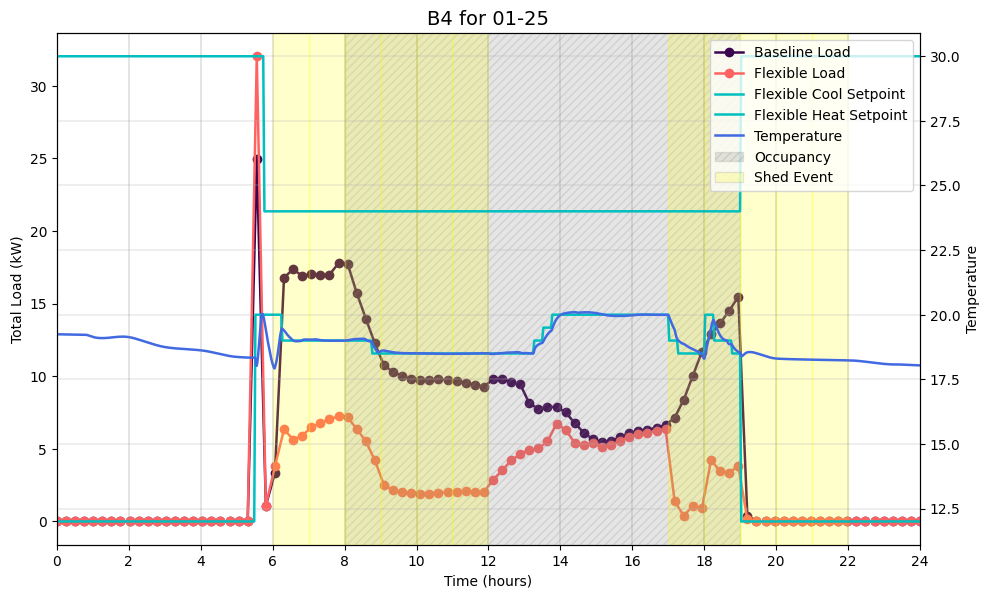

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from matplotlib.patches import Patch

# Assuming your CSV file is named 'your_file.csv'
schedule_df = pd.read_csv('scheduleData_dataset.csv', parse_dates=['time'], index_col='time')
baseline_df = pd.read_csv('baseline_dataset.csv', parse_dates=['time'], index_col='time')
flexible_df = pd.read_csv('flexible_dataset.csv', parse_dates=['time'], index_col='time')
baseline_temp_df = pd.read_csv('baseline_tempData_dataset.csv', parse_dates=['time'], index_col='time')
flexible_temp_df = pd.read_csv('flexible_tempData_dataset.csv', parse_dates=['time'], index_col='time')


baseline_df_selected_day = baseline_df.loc[selected_day]
flexible_df_selected_day = flexible_df.loc[selected_day]
schedule_df_selected_day = schedule_df.loc[selected_day]
baseline_temp_df_selected_day = baseline_temp_df.loc[selected_day]
flexible_temp_df_selected_day = flexible_temp_df.loc[selected_day]

baseline_df_selected_day['Total'] = baseline_df_selected_day.sum(axis=1)
flexible_df_selected_day['Total'] = flexible_df_selected_day.sum(axis=1)

# Resample the selected day data for every 15 minutes and calculate the sum
baseline_df_resampled = baseline_df_selected_day['Total'].resample('15T').mean()/1000
flexible_df_resampled = flexible_df_selected_day['Total'].resample('15T').mean()/1000
occ_df_resampled = schedule_df_selected_day[Occ_identifier].resample('1H').mean()

lowSp_df_resampled = schedule_df_selected_day[LowerSetp_identifier].resample('1H').mean() - 273.15
uppSp_df_resampled = schedule_df_selected_day[UpperSetp_identifier].resample('1H').mean() - 273.15

flexible_cool_df_resampled = flexible_temp_df_selected_day[coolStp_identifier].resample('1T').mean() - 273.15
flexible_heat_df_resampled = flexible_temp_df_selected_day[heatStp_identifier].resample('1T').mean() - 273.15

flexible_temp_df_resampled = flexible_temp_df_selected_day[temperature_identifier].resample('1T').mean() - 273.15

price_df_resampled = schedule_df_selected_day[price_signal_identifier].resample('1H').mean()
#display(price_df_resampled.head(81))


shed_price_df = price_df_resampled[price_df_resampled >= price_threshold] 

#display(baseline_df_resampled.head(81))
#display(shed_price_df.head(81))
#display(occ_df_resampled.head(24))

hours = baseline_df_resampled.index.hour

# Plot the results for both CSV files
plt.figure(figsize=(10, 6))

# Plot electric power 
baseline_load_line, = plt.plot(np.linspace(0, 24, len(baseline_df_resampled)), baseline_df_resampled, linestyle='-', linewidth=1.8, 
                               label='Baseline Load (kW)', color = '#3c054f', marker='o')
flex_load_line, = plt.plot(np.linspace(0, 24, len(flexible_df_resampled)), flexible_df_resampled, linestyle='-', linewidth=1.8, 
                           label='Flexible Load (kW)', color = '#ff6361', marker='o')
plt.ylabel('Total Load (kW)')
plt.xlabel('Time (hours)')

# Plot occupancy on secondary y-axis
ax_temp = plt.twinx()
cool_line, = ax_temp.plot(np.linspace(0, 24, len(flexible_cool_df_resampled)), flexible_cool_df_resampled, color = 'c',
                              linestyle='-', linewidth=1.8, label='Cool setpoint')

heat_line, = ax_temp.plot(np.linspace(0, 24, len(flexible_heat_df_resampled)), flexible_heat_df_resampled, color = 'c',
                              linestyle='-', linewidth=1.8, label='Heat setpoint')

temp_line, = ax_temp.plot(np.linspace(0, 24, len(flexible_temp_df_resampled)), flexible_temp_df_resampled, color = 'royalblue',
                              linestyle='-', linewidth=1.8, label='Temperature')
#comf_line, = ax_occ.plot(np.linspace(0, 24, len(lowSp_df_resampled)), lowSp_df_resampled, color = 'gray',
#                              linestyle='-', linewidth=1.8, label='', marker='o')

#comf_line, = ax_occ.plot(np.linspace(0, 24, len(uppSp_df_resampled)), uppSp_df_resampled, color = 'gray',
#                              linestyle='-', linewidth=1.8, label='', marker='o')
ax_temp.set_ylabel('Temperature')

# Combine the legends
#plt.legend(handles=[baseline_load_line, flex_load_line, cool_line, heat_line, temp_line], loc='upper right')
custom_ticks = np.arange(0, 24, 2)  # Generate ticks from 0 to 24 with step 2
plt.xticks(custom_ticks)

plt.gca().xaxis.set_major_locator(MultipleLocator(2))

plt.title(f'{name_test_case} for {selected_day[5:]}', fontsize=14)

# Adding vertical gridlines
for i in range(0, 24, 2):
    plt.axvline(i, color='gray', linewidth=0.3)

plt.xlim(0, 24)
plt.grid(which='both', axis='both', linewidth=0.3)  # Show both major and minor gridlines

# Adding a shaded area for occ
start_hour = 8
end_hour = 19
plt.axvspan(start_hour, end_hour, alpha=0.2, hatch='////', color='gray')

occ_legend_patch = Patch(facecolor='gray', alpha=0.2, hatch='////', edgecolor='gray')

# Adding a shaded area for shed
for i in range(len(shed_price_df)):
    start_hour = shed_price_df.index[i].hour
    end_hour = shed_price_df.index[i].hour + 1
    plt.axvspan(start_hour, end_hour, alpha=0.2, color='yellow')

shed_legend_patch = Patch(facecolor='yellow', alpha=0.2, edgecolor='gray')

handles = [baseline_load_line, flex_load_line, cool_line, heat_line, temp_line, occ_legend_patch, shed_legend_patch]

labels = ['Baseline Load', 'Flexible Load', 'Flexible Cool Setpoint', 'Flexible Heat Setpoint', 'Temperature', 'Occupancy', 'Shed Event']
plt.legend(handles=handles, labels=labels, loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig(f'{scenario_test_case}_demand_temperature.png')

plt.show()


C:\Users\fafla\AppData\Local\Temp\ipykernel_20376\942524623.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df_selected_day['Total'] = baseline_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW
C:\Users\fafla\AppData\Local\Temp\ipykernel_20376\942524623.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flexible_df_selected_day['Total'] = flexible_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW


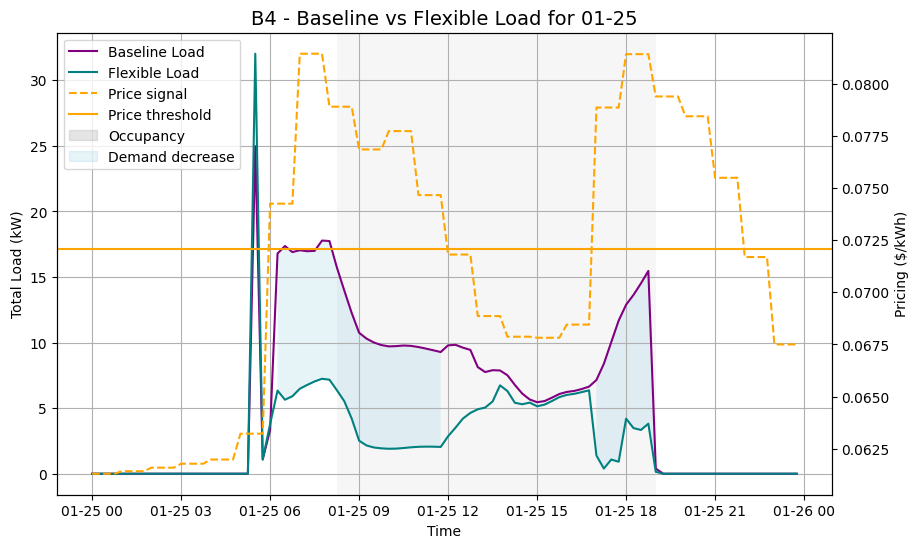

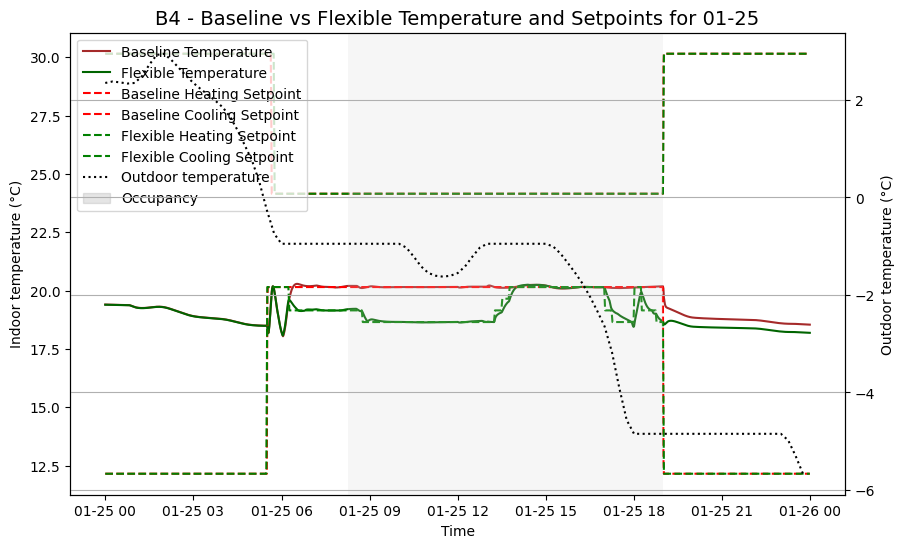

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load datasets
schedule_df = pd.read_csv('scheduleData_dataset.csv')
baseline_df = pd.read_csv('baseline_dataset.csv')
flexible_df = pd.read_csv('flexible_dataset.csv')
baseline_temp_df = pd.read_csv('baseline_tempData_dataset.csv')
flexible_temp_df = pd.read_csv('flexible_tempData_dataset.csv')

# Convert 'time' columns to datetime
schedule_df['time'] = pd.to_datetime(schedule_df['time'])
baseline_df['time'] = pd.to_datetime(baseline_df['time'])
flexible_df['time'] = pd.to_datetime(flexible_df['time'])
baseline_temp_df['time'] = pd.to_datetime(baseline_temp_df['time'])
flexible_temp_df['time'] = pd.to_datetime(flexible_temp_df['time'])

# Resample the data to 15-minute intervals
baseline_resampled_df = baseline_df.resample('15T', on='time').mean()
flexible_resampled_df = flexible_df.resample('15T', on='time').mean()
baseline_temp_resampled_df = baseline_temp_df.resample('1T', on='time').mean()
flexible_temp_resampled_df = flexible_temp_df.resample('1T', on='time').mean()

# Reset the index to make 'time' a column again
baseline_resampled_df.reset_index(inplace=True)
flexible_resampled_df.reset_index(inplace=True)
baseline_temp_resampled_df.reset_index(inplace=True)
flexible_temp_resampled_df.reset_index(inplace=True)

schedule_resampled_df = schedule_df.set_index('time').resample('15T').ffill().reset_index()

# Filter the data for the specific day
baseline_df_selected_day = baseline_resampled_df[baseline_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
flexible_df_selected_day = flexible_resampled_df[flexible_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
schedule_df_selected_day = schedule_resampled_df[schedule_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
baseline_temp_resampled_day_df = baseline_temp_resampled_df[baseline_temp_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
flexible_temp_resampled_day_df = flexible_temp_resampled_df[flexible_temp_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]


# Calculate total load for baseline and flexible scenarios
baseline_df_selected_day['Total'] = baseline_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW
flexible_df_selected_day['Total'] = flexible_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW

# Plot total load over time for baseline and flexible scenarios with occupancy shaded and pricing on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total load
line1, = ax1.plot(baseline_df_selected_day['time'], baseline_df_selected_day['Total'], label='Baseline Load', color='purple')
line2, = ax1.plot(flexible_df_selected_day['time'], flexible_df_selected_day['Total'], label='Flexible Load', color='teal')
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Load (kW)')
ax1.tick_params(axis='y')
plt.grid(True)

# Shade occupancy periods
for i in range(len(schedule_df_selected_day)):
    if schedule_df_selected_day[Occ_identifier].iloc[i] > 0:
        start_time = schedule_df_selected_day['time'].iloc[i]
        end_time = start_time + pd.Timedelta(minutes=15)
        ax1.axvspan(start_time, end_time, alpha=0.2, color='lightgray', ec='none')

# Shade areas between baseline and flexible load where flexible load < baseline load and price > price threshold
ax1.fill_between(
    baseline_df_selected_day['time'],
    flexible_df_selected_day['Total'],
    baseline_df_selected_day['Total'],
    where=(flexible_df_selected_day['Total'] < baseline_df_selected_day['Total']) &
          (schedule_df_selected_day[price_signal_identifier].values > price_threshold),
    facecolor='lightblue',
    alpha=0.3,
    label='Demand decrease'
)

# Create a second y-axis for pricing
ax2 = ax1.twinx()
line3, = ax2.plot(schedule_df_selected_day['time'], schedule_df_selected_day[price_signal_identifier], label='Price signal', linestyle='--', color='orange')
ax2.set_ylabel('Pricing ($/kWh)')
ax2.tick_params(axis='y')

# Add a horizontal line at a specific price value
line4 = ax2.axhline(y=price_threshold, color='orange', linestyle='-', label=f'Price threshold')

# Add a legend for occupancy shading
line5 = mpatches.Patch(color='gray', alpha=0.2, label='Occupancy')
line6 = mpatches.Patch(color='lightblue', alpha=0.3, label='Demand decrease')

# Combine legends from both axes
lines = [line1, line2, line3, line4, line5, line6]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')


plt.title(f'{name_test_case} - Baseline vs Flexible Load for {selected_day[5:]}', fontsize=14)
plt.savefig(f'{scenario_test_case}_demand.png', bbox_inches='tight')
plt.show()

# Plot temperature setpoints and actual temperatures for baseline and flexible scenarios for the new day
fig, ax1 = plt.subplots(figsize=(10, 6))


line1, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[temperature_identifier] - 273, label='Baseline Temperature', color='brown')
line2, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[temperature_identifier] - 273, label='Flexible Temperature', color='darkgreen')
line3, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[heatStp_identifier] - 273, label='Baseline Heating Setpoint', linestyle='--', color='red')
line4, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[coolStp_identifier] - 273, label='Baseline Cooling Setpoint', linestyle='--', color='red')
line5, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[heatStp_identifier] - 273, label='Flexible Heating Setpoint', linestyle='--', color='green')
line6, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[coolStp_identifier] - 273, label='Flexible Cooling Setpoint', linestyle='--', color='green')

ax1.set_xlabel('Time')
ax1.set_ylabel('Indoor temperature (°C)')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
line7, = ax2.plot(schedule_df_selected_day['time'], schedule_df_selected_day[otemp_identifier]-273, label='Outdoor temperature', linestyle=':', color='black')
ax2.set_ylabel('Outdoor temperature (°C)')
ax2.tick_params(axis='y')

# Shade occupancy periods
for i in range(len(schedule_df_selected_day)):
    if schedule_df_selected_day[Occ_identifier].iloc[i] > 0:
        start_time = schedule_df_selected_day['time'].iloc[i]
        end_time = start_time + pd.Timedelta(minutes=15)
        plt.axvspan(start_time, end_time, alpha=0.2, color='lightgray', ec='none')

# Add a proxy artist for the occupancy shading
line8 = mpatches.Patch(color='gray', alpha=0.2, label='Occupancy')

# Combine legends from both axes
lines = [line1, line2, line3, line4, line5, line6, line7, line8]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')


plt.title(f'{name_test_case} - Baseline vs Flexible Temperature and Setpoints for {selected_day[5:]}', fontsize=14)
plt.grid(True)
plt.savefig(f'{scenario_test_case}_temperature.png', bbox_inches='tight')
plt.show()


C:\Users\fafla\AppData\Local\Temp\ipykernel_20376\3812451918.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df_selected_day['Total'] = baseline_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW
C:\Users\fafla\AppData\Local\Temp\ipykernel_20376\3812451918.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flexible_df_selected_day['Total'] = flexible_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW


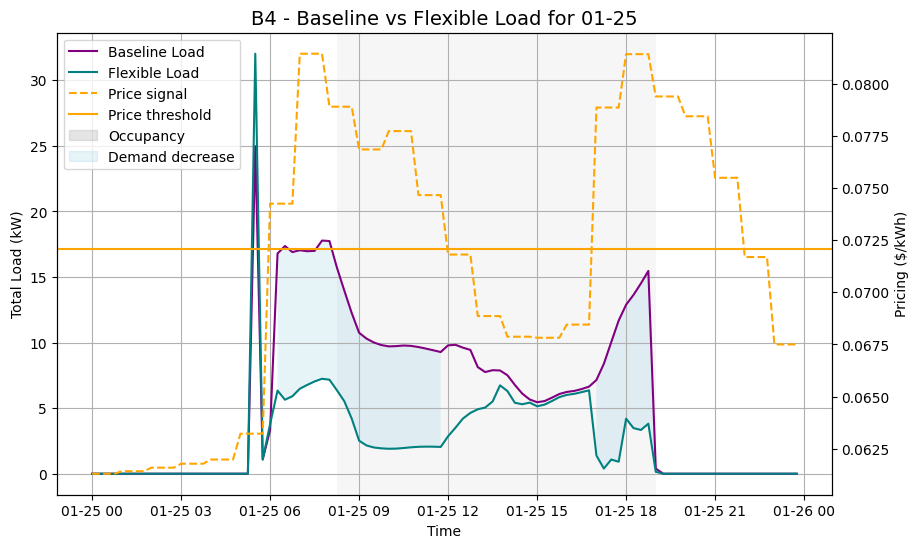

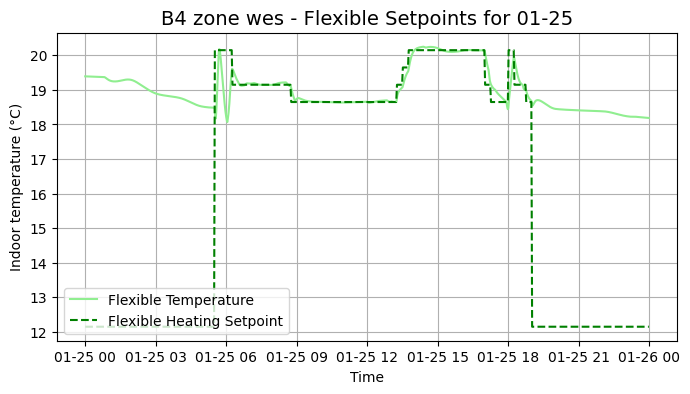

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load datasets
schedule_df = pd.read_csv('scheduleData_dataset.csv')
baseline_df = pd.read_csv('baseline_dataset.csv')
flexible_df = pd.read_csv('flexible_dataset.csv')
baseline_temp_df = pd.read_csv('baseline_tempData_dataset.csv')
flexible_temp_df = pd.read_csv('flexible_tempData_dataset.csv')

# Convert 'time' columns to datetime
schedule_df['time'] = pd.to_datetime(schedule_df['time'])
baseline_df['time'] = pd.to_datetime(baseline_df['time'])
flexible_df['time'] = pd.to_datetime(flexible_df['time'])
baseline_temp_df['time'] = pd.to_datetime(baseline_temp_df['time'])
flexible_temp_df['time'] = pd.to_datetime(flexible_temp_df['time'])

# Resample the data to 15-minute intervals
baseline_resampled_df = baseline_df.resample('15T', on='time').mean()
flexible_resampled_df = flexible_df.resample('15T', on='time').mean()
baseline_temp_resampled_df = baseline_temp_df.resample('1T', on='time').mean()
flexible_temp_resampled_df = flexible_temp_df.resample('1T', on='time').mean()

# Reset the index to make 'time' a column again
baseline_resampled_df.reset_index(inplace=True)
flexible_resampled_df.reset_index(inplace=True)
baseline_temp_resampled_df.reset_index(inplace=True)
flexible_temp_resampled_df.reset_index(inplace=True)

schedule_resampled_df = schedule_df.set_index('time').resample('15T').ffill().reset_index()

# Filter the data for the specific day
baseline_df_selected_day = baseline_resampled_df[baseline_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
flexible_df_selected_day = flexible_resampled_df[flexible_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
schedule_df_selected_day = schedule_resampled_df[schedule_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
baseline_temp_resampled_day_df = baseline_temp_resampled_df[baseline_temp_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
flexible_temp_resampled_day_df = flexible_temp_resampled_df[flexible_temp_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]


# Calculate total load for baseline and flexible scenarios
baseline_df_selected_day['Total'] = baseline_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW
flexible_df_selected_day['Total'] = flexible_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW

# Plot total load over time for baseline and flexible scenarios with occupancy shaded and pricing on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total load
line1, = ax1.plot(baseline_df_selected_day['time'], baseline_df_selected_day['Total'], label='Baseline Load', color='purple')
line2, = ax1.plot(flexible_df_selected_day['time'], flexible_df_selected_day['Total'], label='Flexible Load', color='teal')
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Load (kW)')
ax1.tick_params(axis='y')
plt.grid(True)

# Shade occupancy periods
for i in range(len(schedule_df_selected_day)):
    if schedule_df_selected_day[Occ_identifier].iloc[i] > 0:
        start_time = schedule_df_selected_day['time'].iloc[i]
        end_time = start_time + pd.Timedelta(minutes=15)
        ax1.axvspan(start_time, end_time, alpha=0.2, color='lightgray', ec='none')

# Shade areas between baseline and flexible load where flexible load < baseline load and price > price threshold
ax1.fill_between(
    baseline_df_selected_day['time'],
    flexible_df_selected_day['Total'],
    baseline_df_selected_day['Total'],
    where=(flexible_df_selected_day['Total'] < baseline_df_selected_day['Total']) &
          (schedule_df_selected_day[price_signal_identifier].values > price_threshold),
    facecolor='lightblue',
    alpha=0.3,
    label='Demand decrease'
)

# Create a second y-axis for pricing
ax2 = ax1.twinx()
line3, = ax2.plot(schedule_df_selected_day['time'], schedule_df_selected_day[price_signal_identifier], label='Price signal', linestyle='--', color='orange')
ax2.set_ylabel('Pricing ($/kWh)')
ax2.tick_params(axis='y')

# Add a horizontal line at a specific price value
line4 = ax2.axhline(y=price_threshold, color='orange', linestyle='-', label=f'Price threshold')

# Add a legend for occupancy shading
line5 = mpatches.Patch(color='gray', alpha=0.2, label='Occupancy')
line6 = mpatches.Patch(color='lightblue', alpha=0.3, label='Demand decrease')

# Combine legends from both axes
lines = [line1, line2, line3, line4, line5, line6]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')


plt.title(f'{name_test_case} - Baseline vs Flexible Load for {selected_day[5:]}', fontsize=14)
plt.savefig(f'{scenario_test_case}_{zone}_demand.png', bbox_inches='tight')
plt.show()

# Plot temperature setpoints and actual temperatures for baseline and flexible scenarios for the new day
fig, ax1 = plt.subplots(figsize=(8, 4))


#line1, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[temperature_identifier] - 273, label='Baseline Temperature', color='brown')
line2, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[temperature_identifier] - 273, label='Flexible Temperature', color='lightgreen')
#line3, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[heatStp_identifier] - 273, label='Baseline Heating Setpoint', linestyle='--', color='red')
#line4, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[coolStp_identifier] - 273, label='Baseline Cooling Setpoint', linestyle='--', color='red')
line5, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[heatStp_identifier] - 273, label='Flexible Heating Setpoint', linestyle='--', color='green')
#line6, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[coolStp_identifier] - 273, label='Flexible Cooling Setpoint', linestyle='--', color='green')

ax1.set_xlabel('Time')
ax1.set_ylabel('Indoor temperature (°C)')
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()
# line7, = ax2.plot(schedule_df_selected_day['time'], schedule_df_selected_day[otemp_identifier]-273, label='Outdoor temperature', linestyle=':', color='black')
# ax2.set_ylabel('Outdoor temperature (°C)')
# ax2.tick_params(axis='y')

# Shade occupancy periods
# for i in range(len(schedule_df_selected_day)):
#     if schedule_df_selected_day[Occ_identifier].iloc[i] > 0:
#         start_time = schedule_df_selected_day['time'].iloc[i]
#         end_time = start_time + pd.Timedelta(minutes=15)
#         plt.axvspan(start_time, end_time, alpha=0.2, color='lightgray', ec='none')

# # Add a proxy artist for the occupancy shading
# line8 = mpatches.Patch(color='gray', alpha=0.2, label='Occupancy')

# Combine legends from both axes
lines = [line2, line5] #line1, line2, line3, line4, line5, line6, line7, line8
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')


plt.title(f'{name_test_case} zone {zone} - Flexible Setpoints for {selected_day[5:]}', fontsize=14)
plt.grid(True)
plt.savefig(f'{scenario_test_case}_{zone}_temperature.png', bbox_inches='tight')
plt.show()


In [6]:
# Choose a specific day 
selected_day = '1970-01-25'

name_test_case = 'B4'#: Virtual multizone office simple air'

scenario_test_case = 'B4_VarSc2'

price_signal_identifier = 'PriceElectricPowerHighlyDynamic'

heatStp_identifier = 'hvac_oveZonSupCor_TZonHeaSet_u'
coolStp_identifier = 'hvac_oveZonSupCor_TZonCooSet_u'
temperature_identifier = 'hvac_reaZonCor_TZon_y'

price_threshold = 0.07208500000000001
zone = 'cor'

Occ_identifier = 'Occupancy[cor]'
LowerSetp_identifier = 'LowerSetp[cor]'
UpperSetp_identifier = 'UpperSetp[cor]'

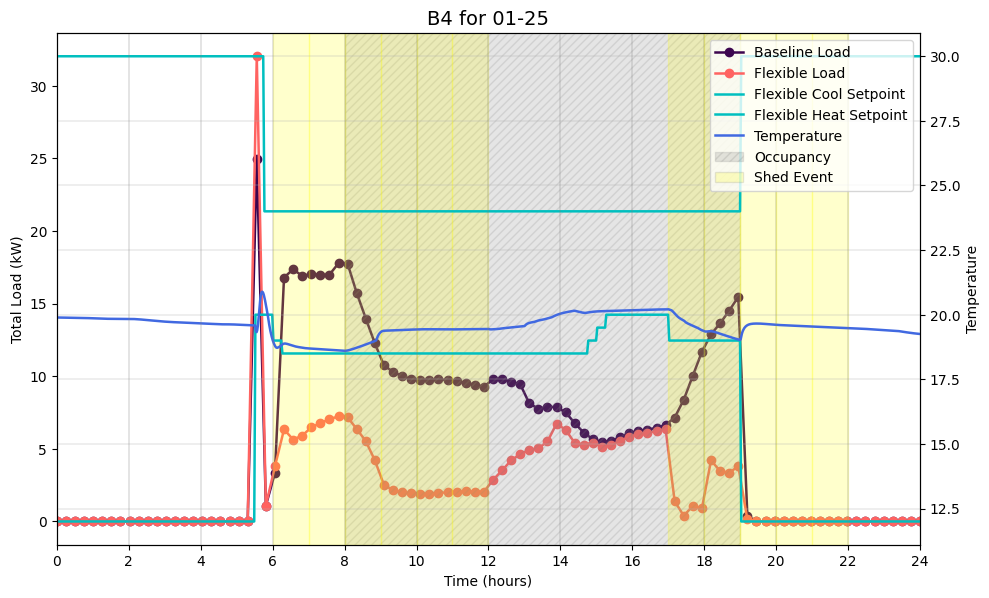

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from matplotlib.patches import Patch

# Assuming your CSV file is named 'your_file.csv'
schedule_df = pd.read_csv('scheduleData_dataset.csv', parse_dates=['time'], index_col='time')
baseline_df = pd.read_csv('baseline_dataset.csv', parse_dates=['time'], index_col='time')
flexible_df = pd.read_csv('flexible_dataset.csv', parse_dates=['time'], index_col='time')
baseline_temp_df = pd.read_csv('baseline_tempData_dataset.csv', parse_dates=['time'], index_col='time')
flexible_temp_df = pd.read_csv('flexible_tempData_dataset.csv', parse_dates=['time'], index_col='time')


baseline_df_selected_day = baseline_df.loc[selected_day]
flexible_df_selected_day = flexible_df.loc[selected_day]
schedule_df_selected_day = schedule_df.loc[selected_day]
baseline_temp_df_selected_day = baseline_temp_df.loc[selected_day]
flexible_temp_df_selected_day = flexible_temp_df.loc[selected_day]

baseline_df_selected_day['Total'] = baseline_df_selected_day.sum(axis=1)
flexible_df_selected_day['Total'] = flexible_df_selected_day.sum(axis=1)

# Resample the selected day data for every 15 minutes and calculate the sum
baseline_df_resampled = baseline_df_selected_day['Total'].resample('15T').mean()/1000
flexible_df_resampled = flexible_df_selected_day['Total'].resample('15T').mean()/1000
occ_df_resampled = schedule_df_selected_day[Occ_identifier].resample('1H').mean()

lowSp_df_resampled = schedule_df_selected_day[LowerSetp_identifier].resample('1H').mean() - 273.15
uppSp_df_resampled = schedule_df_selected_day[UpperSetp_identifier].resample('1H').mean() - 273.15

flexible_cool_df_resampled = flexible_temp_df_selected_day[coolStp_identifier].resample('1T').mean() - 273.15
flexible_heat_df_resampled = flexible_temp_df_selected_day[heatStp_identifier].resample('1T').mean() - 273.15

flexible_temp_df_resampled = flexible_temp_df_selected_day[temperature_identifier].resample('1T').mean() - 273.15

price_df_resampled = schedule_df_selected_day[price_signal_identifier].resample('1H').mean()
#display(price_df_resampled.head(81))


shed_price_df = price_df_resampled[price_df_resampled >= price_threshold] 

#display(baseline_df_resampled.head(81))
#display(shed_price_df.head(81))
#display(occ_df_resampled.head(24))

hours = baseline_df_resampled.index.hour

# Plot the results for both CSV files
plt.figure(figsize=(10, 6))

# Plot electric power 
baseline_load_line, = plt.plot(np.linspace(0, 24, len(baseline_df_resampled)), baseline_df_resampled, linestyle='-', linewidth=1.8, 
                               label='Baseline Load (kW)', color = '#3c054f', marker='o')
flex_load_line, = plt.plot(np.linspace(0, 24, len(flexible_df_resampled)), flexible_df_resampled, linestyle='-', linewidth=1.8, 
                           label='Flexible Load (kW)', color = '#ff6361', marker='o')
plt.ylabel('Total Load (kW)')
plt.xlabel('Time (hours)')

# Plot occupancy on secondary y-axis
ax_temp = plt.twinx()
cool_line, = ax_temp.plot(np.linspace(0, 24, len(flexible_cool_df_resampled)), flexible_cool_df_resampled, color = 'c',
                              linestyle='-', linewidth=1.8, label='Cool setpoint')

heat_line, = ax_temp.plot(np.linspace(0, 24, len(flexible_heat_df_resampled)), flexible_heat_df_resampled, color = 'c',
                              linestyle='-', linewidth=1.8, label='Heat setpoint')

temp_line, = ax_temp.plot(np.linspace(0, 24, len(flexible_temp_df_resampled)), flexible_temp_df_resampled, color = 'royalblue',
                              linestyle='-', linewidth=1.8, label='Temperature')
#comf_line, = ax_occ.plot(np.linspace(0, 24, len(lowSp_df_resampled)), lowSp_df_resampled, color = 'gray',
#                              linestyle='-', linewidth=1.8, label='', marker='o')

#comf_line, = ax_occ.plot(np.linspace(0, 24, len(uppSp_df_resampled)), uppSp_df_resampled, color = 'gray',
#                              linestyle='-', linewidth=1.8, label='', marker='o')
ax_temp.set_ylabel('Temperature')

# Combine the legends
#plt.legend(handles=[baseline_load_line, flex_load_line, cool_line, heat_line, temp_line], loc='upper right')
custom_ticks = np.arange(0, 24, 2)  # Generate ticks from 0 to 24 with step 2
plt.xticks(custom_ticks)

plt.gca().xaxis.set_major_locator(MultipleLocator(2))

plt.title(f'{name_test_case} for {selected_day[5:]}', fontsize=14)

# Adding vertical gridlines
for i in range(0, 24, 2):
    plt.axvline(i, color='gray', linewidth=0.3)

plt.xlim(0, 24)
plt.grid(which='both', axis='both', linewidth=0.3)  # Show both major and minor gridlines

# Adding a shaded area for occ
start_hour = 8
end_hour = 19
plt.axvspan(start_hour, end_hour, alpha=0.2, hatch='////', color='gray')

occ_legend_patch = Patch(facecolor='gray', alpha=0.2, hatch='////', edgecolor='gray')

# Adding a shaded area for shed
for i in range(len(shed_price_df)):
    start_hour = shed_price_df.index[i].hour
    end_hour = shed_price_df.index[i].hour + 1
    plt.axvspan(start_hour, end_hour, alpha=0.2, color='yellow')

shed_legend_patch = Patch(facecolor='yellow', alpha=0.2, edgecolor='gray')

handles = [baseline_load_line, flex_load_line, cool_line, heat_line, temp_line, occ_legend_patch, shed_legend_patch]

labels = ['Baseline Load', 'Flexible Load', 'Flexible Cool Setpoint', 'Flexible Heat Setpoint', 'Temperature', 'Occupancy', 'Shed Event']
plt.legend(handles=handles, labels=labels, loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig(f'{scenario_test_case}_demand_temperature.png')

plt.show()


C:\Users\fafla\AppData\Local\Temp\ipykernel_20376\3812451918.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df_selected_day['Total'] = baseline_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW
C:\Users\fafla\AppData\Local\Temp\ipykernel_20376\3812451918.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flexible_df_selected_day['Total'] = flexible_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW


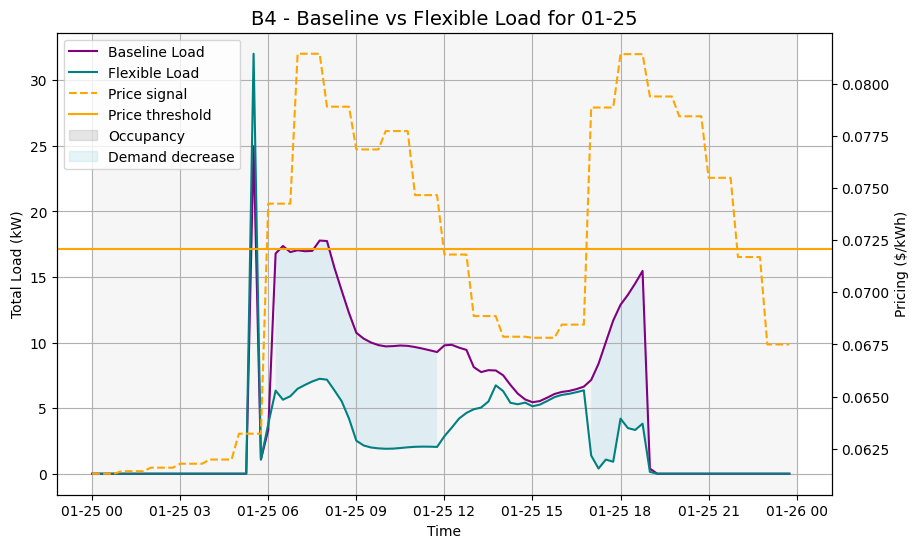

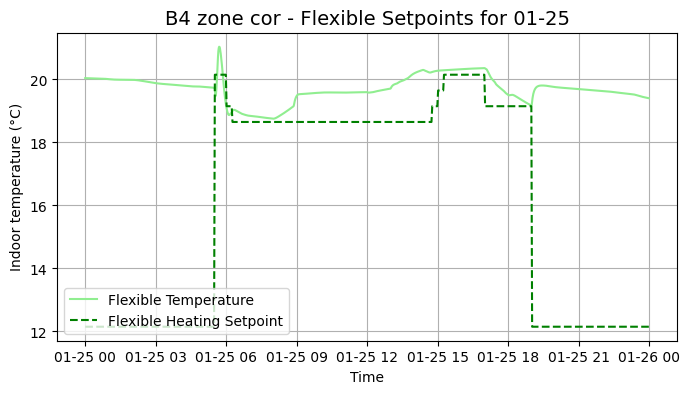

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load datasets
schedule_df = pd.read_csv('scheduleData_dataset.csv')
baseline_df = pd.read_csv('baseline_dataset.csv')
flexible_df = pd.read_csv('flexible_dataset.csv')
baseline_temp_df = pd.read_csv('baseline_tempData_dataset.csv')
flexible_temp_df = pd.read_csv('flexible_tempData_dataset.csv')

# Convert 'time' columns to datetime
schedule_df['time'] = pd.to_datetime(schedule_df['time'])
baseline_df['time'] = pd.to_datetime(baseline_df['time'])
flexible_df['time'] = pd.to_datetime(flexible_df['time'])
baseline_temp_df['time'] = pd.to_datetime(baseline_temp_df['time'])
flexible_temp_df['time'] = pd.to_datetime(flexible_temp_df['time'])

# Resample the data to 15-minute intervals
baseline_resampled_df = baseline_df.resample('15T', on='time').mean()
flexible_resampled_df = flexible_df.resample('15T', on='time').mean()
baseline_temp_resampled_df = baseline_temp_df.resample('1T', on='time').mean()
flexible_temp_resampled_df = flexible_temp_df.resample('1T', on='time').mean()

# Reset the index to make 'time' a column again
baseline_resampled_df.reset_index(inplace=True)
flexible_resampled_df.reset_index(inplace=True)
baseline_temp_resampled_df.reset_index(inplace=True)
flexible_temp_resampled_df.reset_index(inplace=True)

schedule_resampled_df = schedule_df.set_index('time').resample('15T').ffill().reset_index()

# Filter the data for the specific day
baseline_df_selected_day = baseline_resampled_df[baseline_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
flexible_df_selected_day = flexible_resampled_df[flexible_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
schedule_df_selected_day = schedule_resampled_df[schedule_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
baseline_temp_resampled_day_df = baseline_temp_resampled_df[baseline_temp_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
flexible_temp_resampled_day_df = flexible_temp_resampled_df[flexible_temp_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]


# Calculate total load for baseline and flexible scenarios
baseline_df_selected_day['Total'] = baseline_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW
flexible_df_selected_day['Total'] = flexible_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW

# Plot total load over time for baseline and flexible scenarios with occupancy shaded and pricing on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total load
line1, = ax1.plot(baseline_df_selected_day['time'], baseline_df_selected_day['Total'], label='Baseline Load', color='purple')
line2, = ax1.plot(flexible_df_selected_day['time'], flexible_df_selected_day['Total'], label='Flexible Load', color='teal')
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Load (kW)')
ax1.tick_params(axis='y')
plt.grid(True)

# Shade occupancy periods
for i in range(len(schedule_df_selected_day)):
    if schedule_df_selected_day[Occ_identifier].iloc[i] > 0:
        start_time = schedule_df_selected_day['time'].iloc[i]
        end_time = start_time + pd.Timedelta(minutes=15)
        ax1.axvspan(start_time, end_time, alpha=0.2, color='lightgray', ec='none')

# Shade areas between baseline and flexible load where flexible load < baseline load and price > price threshold
ax1.fill_between(
    baseline_df_selected_day['time'],
    flexible_df_selected_day['Total'],
    baseline_df_selected_day['Total'],
    where=(flexible_df_selected_day['Total'] < baseline_df_selected_day['Total']) &
          (schedule_df_selected_day[price_signal_identifier].values > price_threshold),
    facecolor='lightblue',
    alpha=0.3,
    label='Demand decrease'
)

# Create a second y-axis for pricing
ax2 = ax1.twinx()
line3, = ax2.plot(schedule_df_selected_day['time'], schedule_df_selected_day[price_signal_identifier], label='Price signal', linestyle='--', color='orange')
ax2.set_ylabel('Pricing ($/kWh)')
ax2.tick_params(axis='y')

# Add a horizontal line at a specific price value
line4 = ax2.axhline(y=price_threshold, color='orange', linestyle='-', label=f'Price threshold')

# Add a legend for occupancy shading
line5 = mpatches.Patch(color='gray', alpha=0.2, label='Occupancy')
line6 = mpatches.Patch(color='lightblue', alpha=0.3, label='Demand decrease')

# Combine legends from both axes
lines = [line1, line2, line3, line4, line5, line6]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')


plt.title(f'{name_test_case} - Baseline vs Flexible Load for {selected_day[5:]}', fontsize=14)
plt.savefig(f'{scenario_test_case}_{zone}_demand.png', bbox_inches='tight')
plt.show()

# Plot temperature setpoints and actual temperatures for baseline and flexible scenarios for the new day
fig, ax1 = plt.subplots(figsize=(8, 4))


#line1, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[temperature_identifier] - 273, label='Baseline Temperature', color='brown')
line2, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[temperature_identifier] - 273, label='Flexible Temperature', color='lightgreen')
#line3, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[heatStp_identifier] - 273, label='Baseline Heating Setpoint', linestyle='--', color='red')
#line4, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[coolStp_identifier] - 273, label='Baseline Cooling Setpoint', linestyle='--', color='red')
line5, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[heatStp_identifier] - 273, label='Flexible Heating Setpoint', linestyle='--', color='green')
#line6, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[coolStp_identifier] - 273, label='Flexible Cooling Setpoint', linestyle='--', color='green')

ax1.set_xlabel('Time')
ax1.set_ylabel('Indoor temperature (°C)')
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()
# line7, = ax2.plot(schedule_df_selected_day['time'], schedule_df_selected_day[otemp_identifier]-273, label='Outdoor temperature', linestyle=':', color='black')
# ax2.set_ylabel('Outdoor temperature (°C)')
# ax2.tick_params(axis='y')

# Shade occupancy periods
# for i in range(len(schedule_df_selected_day)):
#     if schedule_df_selected_day[Occ_identifier].iloc[i] > 0:
#         start_time = schedule_df_selected_day['time'].iloc[i]
#         end_time = start_time + pd.Timedelta(minutes=15)
#         plt.axvspan(start_time, end_time, alpha=0.2, color='lightgray', ec='none')

# # Add a proxy artist for the occupancy shading
# line8 = mpatches.Patch(color='gray', alpha=0.2, label='Occupancy')

# Combine legends from both axes
lines = [line2, line5] #line1, line2, line3, line4, line5, line6, line7, line8
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')


plt.title(f'{name_test_case} zone {zone} - Flexible Setpoints for {selected_day[5:]}', fontsize=14)
plt.grid(True)
plt.savefig(f'{scenario_test_case}_{zone}_temperature.png', bbox_inches='tight')
plt.show()


In [9]:
# Choose a specific day 
selected_day = '1970-01-25'

name_test_case = 'B4'#: Virtual multizone office simple air'

scenario_test_case = 'B4_VarSc2'

price_signal_identifier = 'PriceElectricPowerHighlyDynamic'

heatStp_identifier = 'hvac_oveZonSupEas_TZonHeaSet_u'
coolStp_identifier = 'hvac_oveZonSupEas_TZonCooSet_u'
temperature_identifier = 'hvac_reaZonEas_TZon_y'

price_threshold = 0.07208500000000001
zone = 'eas'

Occ_identifier = 'Occupancy[eas]'
LowerSetp_identifier = 'LowerSetp[eas]'
UpperSetp_identifier = 'UpperSetp[eas]'

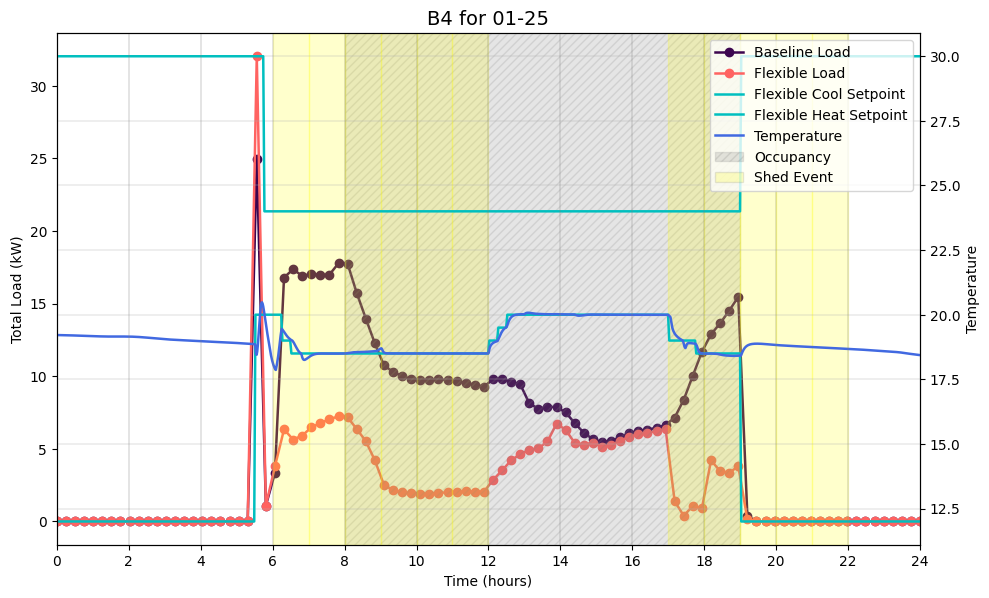

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from matplotlib.patches import Patch

# Assuming your CSV file is named 'your_file.csv'
schedule_df = pd.read_csv('scheduleData_dataset.csv', parse_dates=['time'], index_col='time')
baseline_df = pd.read_csv('baseline_dataset.csv', parse_dates=['time'], index_col='time')
flexible_df = pd.read_csv('flexible_dataset.csv', parse_dates=['time'], index_col='time')
baseline_temp_df = pd.read_csv('baseline_tempData_dataset.csv', parse_dates=['time'], index_col='time')
flexible_temp_df = pd.read_csv('flexible_tempData_dataset.csv', parse_dates=['time'], index_col='time')


baseline_df_selected_day = baseline_df.loc[selected_day]
flexible_df_selected_day = flexible_df.loc[selected_day]
schedule_df_selected_day = schedule_df.loc[selected_day]
baseline_temp_df_selected_day = baseline_temp_df.loc[selected_day]
flexible_temp_df_selected_day = flexible_temp_df.loc[selected_day]

baseline_df_selected_day['Total'] = baseline_df_selected_day.sum(axis=1)
flexible_df_selected_day['Total'] = flexible_df_selected_day.sum(axis=1)

# Resample the selected day data for every 15 minutes and calculate the sum
baseline_df_resampled = baseline_df_selected_day['Total'].resample('15T').mean()/1000
flexible_df_resampled = flexible_df_selected_day['Total'].resample('15T').mean()/1000
occ_df_resampled = schedule_df_selected_day[Occ_identifier].resample('1H').mean()

lowSp_df_resampled = schedule_df_selected_day[LowerSetp_identifier].resample('1H').mean() - 273.15
uppSp_df_resampled = schedule_df_selected_day[UpperSetp_identifier].resample('1H').mean() - 273.15

flexible_cool_df_resampled = flexible_temp_df_selected_day[coolStp_identifier].resample('1T').mean() - 273.15
flexible_heat_df_resampled = flexible_temp_df_selected_day[heatStp_identifier].resample('1T').mean() - 273.15

flexible_temp_df_resampled = flexible_temp_df_selected_day[temperature_identifier].resample('1T').mean() - 273.15

price_df_resampled = schedule_df_selected_day[price_signal_identifier].resample('1H').mean()
#display(price_df_resampled.head(81))


shed_price_df = price_df_resampled[price_df_resampled >= price_threshold] 

#display(baseline_df_resampled.head(81))
#display(shed_price_df.head(81))
#display(occ_df_resampled.head(24))

hours = baseline_df_resampled.index.hour

# Plot the results for both CSV files
plt.figure(figsize=(10, 6))

# Plot electric power 
baseline_load_line, = plt.plot(np.linspace(0, 24, len(baseline_df_resampled)), baseline_df_resampled, linestyle='-', linewidth=1.8, 
                               label='Baseline Load (kW)', color = '#3c054f', marker='o')
flex_load_line, = plt.plot(np.linspace(0, 24, len(flexible_df_resampled)), flexible_df_resampled, linestyle='-', linewidth=1.8, 
                           label='Flexible Load (kW)', color = '#ff6361', marker='o')
plt.ylabel('Total Load (kW)')
plt.xlabel('Time (hours)')

# Plot occupancy on secondary y-axis
ax_temp = plt.twinx()
cool_line, = ax_temp.plot(np.linspace(0, 24, len(flexible_cool_df_resampled)), flexible_cool_df_resampled, color = 'c',
                              linestyle='-', linewidth=1.8, label='Cool setpoint')

heat_line, = ax_temp.plot(np.linspace(0, 24, len(flexible_heat_df_resampled)), flexible_heat_df_resampled, color = 'c',
                              linestyle='-', linewidth=1.8, label='Heat setpoint')

temp_line, = ax_temp.plot(np.linspace(0, 24, len(flexible_temp_df_resampled)), flexible_temp_df_resampled, color = 'royalblue',
                              linestyle='-', linewidth=1.8, label='Temperature')
#comf_line, = ax_occ.plot(np.linspace(0, 24, len(lowSp_df_resampled)), lowSp_df_resampled, color = 'gray',
#                              linestyle='-', linewidth=1.8, label='', marker='o')

#comf_line, = ax_occ.plot(np.linspace(0, 24, len(uppSp_df_resampled)), uppSp_df_resampled, color = 'gray',
#                              linestyle='-', linewidth=1.8, label='', marker='o')
ax_temp.set_ylabel('Temperature')

# Combine the legends
#plt.legend(handles=[baseline_load_line, flex_load_line, cool_line, heat_line, temp_line], loc='upper right')
custom_ticks = np.arange(0, 24, 2)  # Generate ticks from 0 to 24 with step 2
plt.xticks(custom_ticks)

plt.gca().xaxis.set_major_locator(MultipleLocator(2))

plt.title(f'{name_test_case} for {selected_day[5:]}', fontsize=14)

# Adding vertical gridlines
for i in range(0, 24, 2):
    plt.axvline(i, color='gray', linewidth=0.3)

plt.xlim(0, 24)
plt.grid(which='both', axis='both', linewidth=0.3)  # Show both major and minor gridlines

# Adding a shaded area for occ
start_hour = 8
end_hour = 19
plt.axvspan(start_hour, end_hour, alpha=0.2, hatch='////', color='gray')

occ_legend_patch = Patch(facecolor='gray', alpha=0.2, hatch='////', edgecolor='gray')

# Adding a shaded area for shed
for i in range(len(shed_price_df)):
    start_hour = shed_price_df.index[i].hour
    end_hour = shed_price_df.index[i].hour + 1
    plt.axvspan(start_hour, end_hour, alpha=0.2, color='yellow')

shed_legend_patch = Patch(facecolor='yellow', alpha=0.2, edgecolor='gray')

handles = [baseline_load_line, flex_load_line, cool_line, heat_line, temp_line, occ_legend_patch, shed_legend_patch]

labels = ['Baseline Load', 'Flexible Load', 'Flexible Cool Setpoint', 'Flexible Heat Setpoint', 'Temperature', 'Occupancy', 'Shed Event']
plt.legend(handles=handles, labels=labels, loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig(f'{scenario_test_case}_demand_temperature.png')

plt.show()


C:\Users\fafla\AppData\Local\Temp\ipykernel_20376\3812451918.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df_selected_day['Total'] = baseline_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW
C:\Users\fafla\AppData\Local\Temp\ipykernel_20376\3812451918.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flexible_df_selected_day['Total'] = flexible_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW


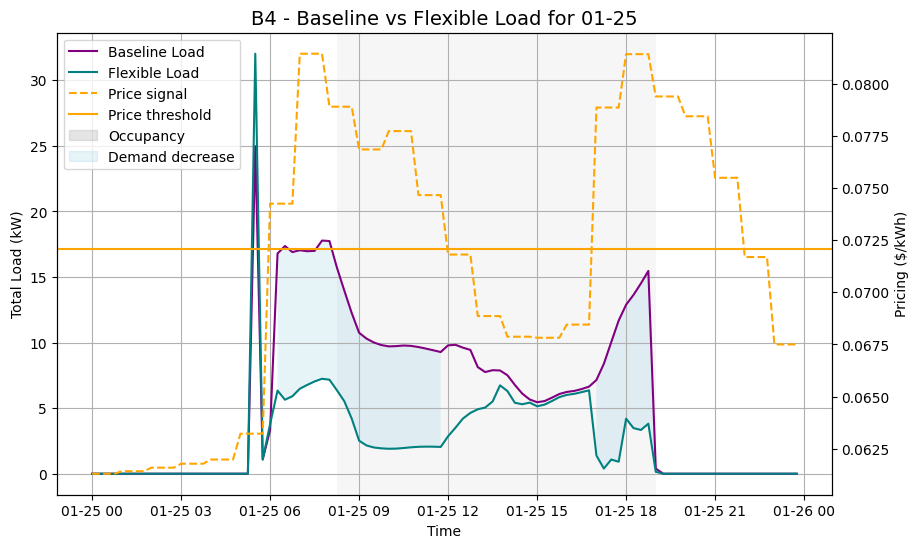

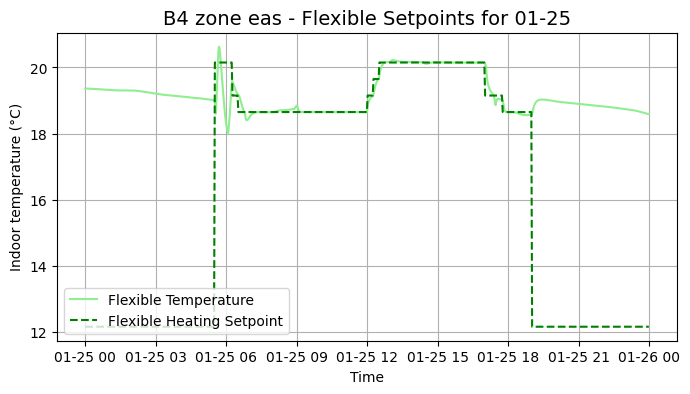

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load datasets
schedule_df = pd.read_csv('scheduleData_dataset.csv')
baseline_df = pd.read_csv('baseline_dataset.csv')
flexible_df = pd.read_csv('flexible_dataset.csv')
baseline_temp_df = pd.read_csv('baseline_tempData_dataset.csv')
flexible_temp_df = pd.read_csv('flexible_tempData_dataset.csv')

# Convert 'time' columns to datetime
schedule_df['time'] = pd.to_datetime(schedule_df['time'])
baseline_df['time'] = pd.to_datetime(baseline_df['time'])
flexible_df['time'] = pd.to_datetime(flexible_df['time'])
baseline_temp_df['time'] = pd.to_datetime(baseline_temp_df['time'])
flexible_temp_df['time'] = pd.to_datetime(flexible_temp_df['time'])

# Resample the data to 15-minute intervals
baseline_resampled_df = baseline_df.resample('15T', on='time').mean()
flexible_resampled_df = flexible_df.resample('15T', on='time').mean()
baseline_temp_resampled_df = baseline_temp_df.resample('1T', on='time').mean()
flexible_temp_resampled_df = flexible_temp_df.resample('1T', on='time').mean()

# Reset the index to make 'time' a column again
baseline_resampled_df.reset_index(inplace=True)
flexible_resampled_df.reset_index(inplace=True)
baseline_temp_resampled_df.reset_index(inplace=True)
flexible_temp_resampled_df.reset_index(inplace=True)

schedule_resampled_df = schedule_df.set_index('time').resample('15T').ffill().reset_index()

# Filter the data for the specific day
baseline_df_selected_day = baseline_resampled_df[baseline_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
flexible_df_selected_day = flexible_resampled_df[flexible_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
schedule_df_selected_day = schedule_resampled_df[schedule_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
baseline_temp_resampled_day_df = baseline_temp_resampled_df[baseline_temp_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
flexible_temp_resampled_day_df = flexible_temp_resampled_df[flexible_temp_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]


# Calculate total load for baseline and flexible scenarios
baseline_df_selected_day['Total'] = baseline_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW
flexible_df_selected_day['Total'] = flexible_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW

# Plot total load over time for baseline and flexible scenarios with occupancy shaded and pricing on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total load
line1, = ax1.plot(baseline_df_selected_day['time'], baseline_df_selected_day['Total'], label='Baseline Load', color='purple')
line2, = ax1.plot(flexible_df_selected_day['time'], flexible_df_selected_day['Total'], label='Flexible Load', color='teal')
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Load (kW)')
ax1.tick_params(axis='y')
plt.grid(True)

# Shade occupancy periods
for i in range(len(schedule_df_selected_day)):
    if schedule_df_selected_day[Occ_identifier].iloc[i] > 0:
        start_time = schedule_df_selected_day['time'].iloc[i]
        end_time = start_time + pd.Timedelta(minutes=15)
        ax1.axvspan(start_time, end_time, alpha=0.2, color='lightgray', ec='none')

# Shade areas between baseline and flexible load where flexible load < baseline load and price > price threshold
ax1.fill_between(
    baseline_df_selected_day['time'],
    flexible_df_selected_day['Total'],
    baseline_df_selected_day['Total'],
    where=(flexible_df_selected_day['Total'] < baseline_df_selected_day['Total']) &
          (schedule_df_selected_day[price_signal_identifier].values > price_threshold),
    facecolor='lightblue',
    alpha=0.3,
    label='Demand decrease'
)

# Create a second y-axis for pricing
ax2 = ax1.twinx()
line3, = ax2.plot(schedule_df_selected_day['time'], schedule_df_selected_day[price_signal_identifier], label='Price signal', linestyle='--', color='orange')
ax2.set_ylabel('Pricing ($/kWh)')
ax2.tick_params(axis='y')

# Add a horizontal line at a specific price value
line4 = ax2.axhline(y=price_threshold, color='orange', linestyle='-', label=f'Price threshold')

# Add a legend for occupancy shading
line5 = mpatches.Patch(color='gray', alpha=0.2, label='Occupancy')
line6 = mpatches.Patch(color='lightblue', alpha=0.3, label='Demand decrease')

# Combine legends from both axes
lines = [line1, line2, line3, line4, line5, line6]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')


plt.title(f'{name_test_case} - Baseline vs Flexible Load for {selected_day[5:]}', fontsize=14)
plt.savefig(f'{scenario_test_case}_{zone}_demand.png', bbox_inches='tight')
plt.show()

# Plot temperature setpoints and actual temperatures for baseline and flexible scenarios for the new day
fig, ax1 = plt.subplots(figsize=(8, 4))


#line1, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[temperature_identifier] - 273, label='Baseline Temperature', color='brown')
line2, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[temperature_identifier] - 273, label='Flexible Temperature', color='lightgreen')
#line3, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[heatStp_identifier] - 273, label='Baseline Heating Setpoint', linestyle='--', color='red')
#line4, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[coolStp_identifier] - 273, label='Baseline Cooling Setpoint', linestyle='--', color='red')
line5, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[heatStp_identifier] - 273, label='Flexible Heating Setpoint', linestyle='--', color='green')
#line6, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[coolStp_identifier] - 273, label='Flexible Cooling Setpoint', linestyle='--', color='green')

ax1.set_xlabel('Time')
ax1.set_ylabel('Indoor temperature (°C)')
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()
# line7, = ax2.plot(schedule_df_selected_day['time'], schedule_df_selected_day[otemp_identifier]-273, label='Outdoor temperature', linestyle=':', color='black')
# ax2.set_ylabel('Outdoor temperature (°C)')
# ax2.tick_params(axis='y')

# Shade occupancy periods
# for i in range(len(schedule_df_selected_day)):
#     if schedule_df_selected_day[Occ_identifier].iloc[i] > 0:
#         start_time = schedule_df_selected_day['time'].iloc[i]
#         end_time = start_time + pd.Timedelta(minutes=15)
#         plt.axvspan(start_time, end_time, alpha=0.2, color='lightgray', ec='none')

# # Add a proxy artist for the occupancy shading
# line8 = mpatches.Patch(color='gray', alpha=0.2, label='Occupancy')

# Combine legends from both axes
lines = [line2, line5] #line1, line2, line3, line4, line5, line6, line7, line8
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')


plt.title(f'{name_test_case} zone {zone} - Flexible Setpoints for {selected_day[5:]}', fontsize=14)
plt.grid(True)
plt.savefig(f'{scenario_test_case}_{zone}_temperature.png', bbox_inches='tight')
plt.show()


In [12]:
# Choose a specific day 
selected_day = '1970-01-25'

name_test_case = 'B4'#: Virtual multizone office simple air'

scenario_test_case = 'B4_VarSc2'

price_signal_identifier = 'PriceElectricPowerHighlyDynamic'

heatStp_identifier = 'hvac_oveZonSupNor_TZonHeaSet_u'
coolStp_identifier = 'hvac_oveZonSupNor_TZonCooSet_u'
temperature_identifier = 'hvac_reaZonNor_TZon_y'

price_threshold = 0.07208500000000001
zone = 'nor'

Occ_identifier = 'Occupancy[nor]'
LowerSetp_identifier = 'LowerSetp[nor]'
UpperSetp_identifier = 'UpperSetp[nor]'

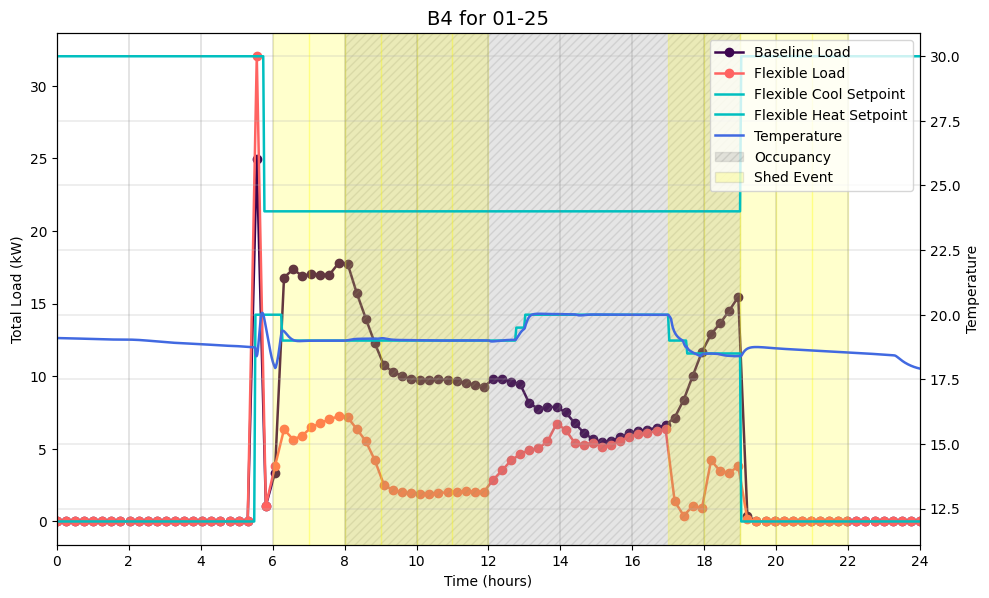

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from matplotlib.patches import Patch

# Assuming your CSV file is named 'your_file.csv'
schedule_df = pd.read_csv('scheduleData_dataset.csv', parse_dates=['time'], index_col='time')
baseline_df = pd.read_csv('baseline_dataset.csv', parse_dates=['time'], index_col='time')
flexible_df = pd.read_csv('flexible_dataset.csv', parse_dates=['time'], index_col='time')
baseline_temp_df = pd.read_csv('baseline_tempData_dataset.csv', parse_dates=['time'], index_col='time')
flexible_temp_df = pd.read_csv('flexible_tempData_dataset.csv', parse_dates=['time'], index_col='time')


baseline_df_selected_day = baseline_df.loc[selected_day]
flexible_df_selected_day = flexible_df.loc[selected_day]
schedule_df_selected_day = schedule_df.loc[selected_day]
baseline_temp_df_selected_day = baseline_temp_df.loc[selected_day]
flexible_temp_df_selected_day = flexible_temp_df.loc[selected_day]

baseline_df_selected_day['Total'] = baseline_df_selected_day.sum(axis=1)
flexible_df_selected_day['Total'] = flexible_df_selected_day.sum(axis=1)

# Resample the selected day data for every 15 minutes and calculate the sum
baseline_df_resampled = baseline_df_selected_day['Total'].resample('15T').mean()/1000
flexible_df_resampled = flexible_df_selected_day['Total'].resample('15T').mean()/1000
occ_df_resampled = schedule_df_selected_day[Occ_identifier].resample('1H').mean()

lowSp_df_resampled = schedule_df_selected_day[LowerSetp_identifier].resample('1H').mean() - 273.15
uppSp_df_resampled = schedule_df_selected_day[UpperSetp_identifier].resample('1H').mean() - 273.15

flexible_cool_df_resampled = flexible_temp_df_selected_day[coolStp_identifier].resample('1T').mean() - 273.15
flexible_heat_df_resampled = flexible_temp_df_selected_day[heatStp_identifier].resample('1T').mean() - 273.15

flexible_temp_df_resampled = flexible_temp_df_selected_day[temperature_identifier].resample('1T').mean() - 273.15

price_df_resampled = schedule_df_selected_day[price_signal_identifier].resample('1H').mean()
#display(price_df_resampled.head(81))


shed_price_df = price_df_resampled[price_df_resampled >= price_threshold] 

#display(baseline_df_resampled.head(81))
#display(shed_price_df.head(81))
#display(occ_df_resampled.head(24))

hours = baseline_df_resampled.index.hour

# Plot the results for both CSV files
plt.figure(figsize=(10, 6))

# Plot electric power 
baseline_load_line, = plt.plot(np.linspace(0, 24, len(baseline_df_resampled)), baseline_df_resampled, linestyle='-', linewidth=1.8, 
                               label='Baseline Load (kW)', color = '#3c054f', marker='o')
flex_load_line, = plt.plot(np.linspace(0, 24, len(flexible_df_resampled)), flexible_df_resampled, linestyle='-', linewidth=1.8, 
                           label='Flexible Load (kW)', color = '#ff6361', marker='o')
plt.ylabel('Total Load (kW)')
plt.xlabel('Time (hours)')

# Plot occupancy on secondary y-axis
ax_temp = plt.twinx()
cool_line, = ax_temp.plot(np.linspace(0, 24, len(flexible_cool_df_resampled)), flexible_cool_df_resampled, color = 'c',
                              linestyle='-', linewidth=1.8, label='Cool setpoint')

heat_line, = ax_temp.plot(np.linspace(0, 24, len(flexible_heat_df_resampled)), flexible_heat_df_resampled, color = 'c',
                              linestyle='-', linewidth=1.8, label='Heat setpoint')

temp_line, = ax_temp.plot(np.linspace(0, 24, len(flexible_temp_df_resampled)), flexible_temp_df_resampled, color = 'royalblue',
                              linestyle='-', linewidth=1.8, label='Temperature')
#comf_line, = ax_occ.plot(np.linspace(0, 24, len(lowSp_df_resampled)), lowSp_df_resampled, color = 'gray',
#                              linestyle='-', linewidth=1.8, label='', marker='o')

#comf_line, = ax_occ.plot(np.linspace(0, 24, len(uppSp_df_resampled)), uppSp_df_resampled, color = 'gray',
#                              linestyle='-', linewidth=1.8, label='', marker='o')
ax_temp.set_ylabel('Temperature')

# Combine the legends
#plt.legend(handles=[baseline_load_line, flex_load_line, cool_line, heat_line, temp_line], loc='upper right')
custom_ticks = np.arange(0, 24, 2)  # Generate ticks from 0 to 24 with step 2
plt.xticks(custom_ticks)

plt.gca().xaxis.set_major_locator(MultipleLocator(2))

plt.title(f'{name_test_case} for {selected_day[5:]}', fontsize=14)

# Adding vertical gridlines
for i in range(0, 24, 2):
    plt.axvline(i, color='gray', linewidth=0.3)

plt.xlim(0, 24)
plt.grid(which='both', axis='both', linewidth=0.3)  # Show both major and minor gridlines

# Adding a shaded area for occ
start_hour = 8
end_hour = 19
plt.axvspan(start_hour, end_hour, alpha=0.2, hatch='////', color='gray')

occ_legend_patch = Patch(facecolor='gray', alpha=0.2, hatch='////', edgecolor='gray')

# Adding a shaded area for shed
for i in range(len(shed_price_df)):
    start_hour = shed_price_df.index[i].hour
    end_hour = shed_price_df.index[i].hour + 1
    plt.axvspan(start_hour, end_hour, alpha=0.2, color='yellow')

shed_legend_patch = Patch(facecolor='yellow', alpha=0.2, edgecolor='gray')

handles = [baseline_load_line, flex_load_line, cool_line, heat_line, temp_line, occ_legend_patch, shed_legend_patch]

labels = ['Baseline Load', 'Flexible Load', 'Flexible Cool Setpoint', 'Flexible Heat Setpoint', 'Temperature', 'Occupancy', 'Shed Event']
plt.legend(handles=handles, labels=labels, loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig(f'{scenario_test_case}_demand_temperature.png')

plt.show()


C:\Users\fafla\AppData\Local\Temp\ipykernel_20376\3812451918.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df_selected_day['Total'] = baseline_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW
C:\Users\fafla\AppData\Local\Temp\ipykernel_20376\3812451918.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flexible_df_selected_day['Total'] = flexible_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW


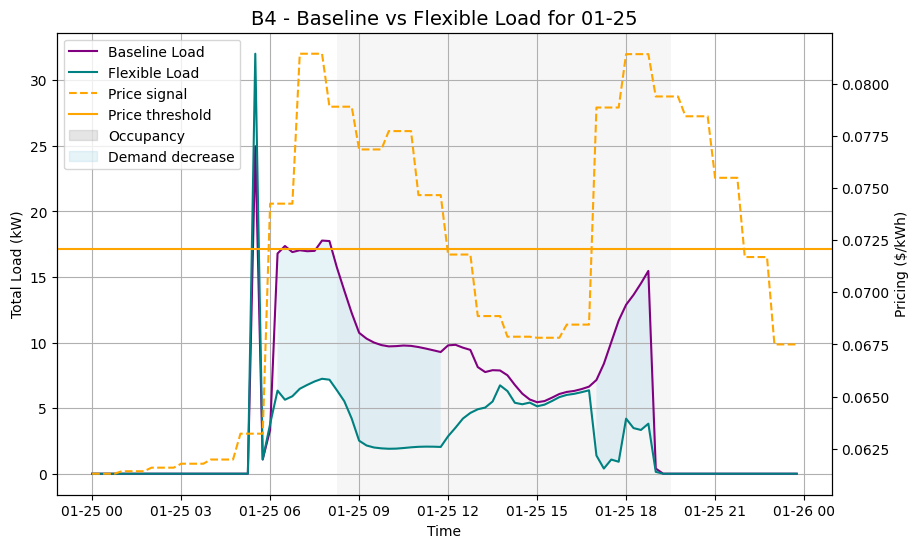

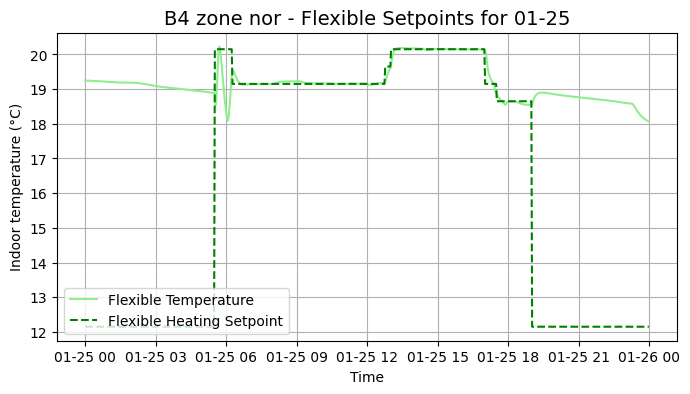

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load datasets
schedule_df = pd.read_csv('scheduleData_dataset.csv')
baseline_df = pd.read_csv('baseline_dataset.csv')
flexible_df = pd.read_csv('flexible_dataset.csv')
baseline_temp_df = pd.read_csv('baseline_tempData_dataset.csv')
flexible_temp_df = pd.read_csv('flexible_tempData_dataset.csv')

# Convert 'time' columns to datetime
schedule_df['time'] = pd.to_datetime(schedule_df['time'])
baseline_df['time'] = pd.to_datetime(baseline_df['time'])
flexible_df['time'] = pd.to_datetime(flexible_df['time'])
baseline_temp_df['time'] = pd.to_datetime(baseline_temp_df['time'])
flexible_temp_df['time'] = pd.to_datetime(flexible_temp_df['time'])

# Resample the data to 15-minute intervals
baseline_resampled_df = baseline_df.resample('15T', on='time').mean()
flexible_resampled_df = flexible_df.resample('15T', on='time').mean()
baseline_temp_resampled_df = baseline_temp_df.resample('1T', on='time').mean()
flexible_temp_resampled_df = flexible_temp_df.resample('1T', on='time').mean()

# Reset the index to make 'time' a column again
baseline_resampled_df.reset_index(inplace=True)
flexible_resampled_df.reset_index(inplace=True)
baseline_temp_resampled_df.reset_index(inplace=True)
flexible_temp_resampled_df.reset_index(inplace=True)

schedule_resampled_df = schedule_df.set_index('time').resample('15T').ffill().reset_index()

# Filter the data for the specific day
baseline_df_selected_day = baseline_resampled_df[baseline_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
flexible_df_selected_day = flexible_resampled_df[flexible_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
schedule_df_selected_day = schedule_resampled_df[schedule_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
baseline_temp_resampled_day_df = baseline_temp_resampled_df[baseline_temp_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
flexible_temp_resampled_day_df = flexible_temp_resampled_df[flexible_temp_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]


# Calculate total load for baseline and flexible scenarios
baseline_df_selected_day['Total'] = baseline_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW
flexible_df_selected_day['Total'] = flexible_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW

# Plot total load over time for baseline and flexible scenarios with occupancy shaded and pricing on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total load
line1, = ax1.plot(baseline_df_selected_day['time'], baseline_df_selected_day['Total'], label='Baseline Load', color='purple')
line2, = ax1.plot(flexible_df_selected_day['time'], flexible_df_selected_day['Total'], label='Flexible Load', color='teal')
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Load (kW)')
ax1.tick_params(axis='y')
plt.grid(True)

# Shade occupancy periods
for i in range(len(schedule_df_selected_day)):
    if schedule_df_selected_day[Occ_identifier].iloc[i] > 0:
        start_time = schedule_df_selected_day['time'].iloc[i]
        end_time = start_time + pd.Timedelta(minutes=15)
        ax1.axvspan(start_time, end_time, alpha=0.2, color='lightgray', ec='none')

# Shade areas between baseline and flexible load where flexible load < baseline load and price > price threshold
ax1.fill_between(
    baseline_df_selected_day['time'],
    flexible_df_selected_day['Total'],
    baseline_df_selected_day['Total'],
    where=(flexible_df_selected_day['Total'] < baseline_df_selected_day['Total']) &
          (schedule_df_selected_day[price_signal_identifier].values > price_threshold),
    facecolor='lightblue',
    alpha=0.3,
    label='Demand decrease'
)

# Create a second y-axis for pricing
ax2 = ax1.twinx()
line3, = ax2.plot(schedule_df_selected_day['time'], schedule_df_selected_day[price_signal_identifier], label='Price signal', linestyle='--', color='orange')
ax2.set_ylabel('Pricing ($/kWh)')
ax2.tick_params(axis='y')

# Add a horizontal line at a specific price value
line4 = ax2.axhline(y=price_threshold, color='orange', linestyle='-', label=f'Price threshold')

# Add a legend for occupancy shading
line5 = mpatches.Patch(color='gray', alpha=0.2, label='Occupancy')
line6 = mpatches.Patch(color='lightblue', alpha=0.3, label='Demand decrease')

# Combine legends from both axes
lines = [line1, line2, line3, line4, line5, line6]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')


plt.title(f'{name_test_case} - Baseline vs Flexible Load for {selected_day[5:]}', fontsize=14)
plt.savefig(f'{scenario_test_case}_{zone}_demand.png', bbox_inches='tight')
plt.show()

# Plot temperature setpoints and actual temperatures for baseline and flexible scenarios for the new day
fig, ax1 = plt.subplots(figsize=(8, 4))


#line1, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[temperature_identifier] - 273, label='Baseline Temperature', color='brown')
line2, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[temperature_identifier] - 273, label='Flexible Temperature', color='lightgreen')
#line3, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[heatStp_identifier] - 273, label='Baseline Heating Setpoint', linestyle='--', color='red')
#line4, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[coolStp_identifier] - 273, label='Baseline Cooling Setpoint', linestyle='--', color='red')
line5, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[heatStp_identifier] - 273, label='Flexible Heating Setpoint', linestyle='--', color='green')
#line6, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[coolStp_identifier] - 273, label='Flexible Cooling Setpoint', linestyle='--', color='green')

ax1.set_xlabel('Time')
ax1.set_ylabel('Indoor temperature (°C)')
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()
# line7, = ax2.plot(schedule_df_selected_day['time'], schedule_df_selected_day[otemp_identifier]-273, label='Outdoor temperature', linestyle=':', color='black')
# ax2.set_ylabel('Outdoor temperature (°C)')
# ax2.tick_params(axis='y')

# Shade occupancy periods
# for i in range(len(schedule_df_selected_day)):
#     if schedule_df_selected_day[Occ_identifier].iloc[i] > 0:
#         start_time = schedule_df_selected_day['time'].iloc[i]
#         end_time = start_time + pd.Timedelta(minutes=15)
#         plt.axvspan(start_time, end_time, alpha=0.2, color='lightgray', ec='none')

# # Add a proxy artist for the occupancy shading
# line8 = mpatches.Patch(color='gray', alpha=0.2, label='Occupancy')

# Combine legends from both axes
lines = [line2, line5] #line1, line2, line3, line4, line5, line6, line7, line8
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')


plt.title(f'{name_test_case} zone {zone} - Flexible Setpoints for {selected_day[5:]}', fontsize=14)
plt.grid(True)
plt.savefig(f'{scenario_test_case}_{zone}_temperature.png', bbox_inches='tight')
plt.show()


In [15]:
# Choose a specific day 
selected_day = '1970-01-25'

name_test_case = 'B4'#: Virtual multizone office simple air'

scenario_test_case = 'B4_VarSc2'

price_signal_identifier = 'PriceElectricPowerHighlyDynamic'

heatStp_identifier = 'hvac_oveZonSupSou_TZonHeaSet_u'
coolStp_identifier = 'hvac_oveZonSupSou_TZonCooSet_u'
temperature_identifier = 'hvac_reaZonSou_TZon_y'

price_threshold = 0.07208500000000001
zone = 'sou'

Occ_identifier = 'Occupancy[sou]'
LowerSetp_identifier = 'LowerSetp[sou]'
UpperSetp_identifier = 'UpperSetp[sou]'

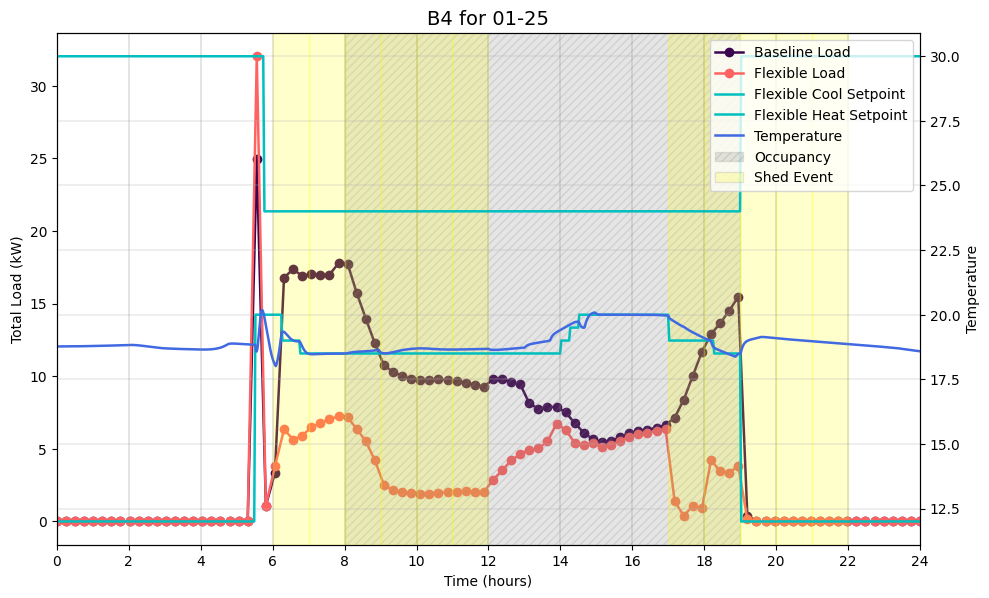

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from matplotlib.patches import Patch

# Assuming your CSV file is named 'your_file.csv'
schedule_df = pd.read_csv('scheduleData_dataset.csv', parse_dates=['time'], index_col='time')
baseline_df = pd.read_csv('baseline_dataset.csv', parse_dates=['time'], index_col='time')
flexible_df = pd.read_csv('flexible_dataset.csv', parse_dates=['time'], index_col='time')
baseline_temp_df = pd.read_csv('baseline_tempData_dataset.csv', parse_dates=['time'], index_col='time')
flexible_temp_df = pd.read_csv('flexible_tempData_dataset.csv', parse_dates=['time'], index_col='time')


baseline_df_selected_day = baseline_df.loc[selected_day]
flexible_df_selected_day = flexible_df.loc[selected_day]
schedule_df_selected_day = schedule_df.loc[selected_day]
baseline_temp_df_selected_day = baseline_temp_df.loc[selected_day]
flexible_temp_df_selected_day = flexible_temp_df.loc[selected_day]

baseline_df_selected_day['Total'] = baseline_df_selected_day.sum(axis=1)
flexible_df_selected_day['Total'] = flexible_df_selected_day.sum(axis=1)

# Resample the selected day data for every 15 minutes and calculate the sum
baseline_df_resampled = baseline_df_selected_day['Total'].resample('15T').mean()/1000
flexible_df_resampled = flexible_df_selected_day['Total'].resample('15T').mean()/1000
occ_df_resampled = schedule_df_selected_day[Occ_identifier].resample('1H').mean()

lowSp_df_resampled = schedule_df_selected_day[LowerSetp_identifier].resample('1H').mean() - 273.15
uppSp_df_resampled = schedule_df_selected_day[UpperSetp_identifier].resample('1H').mean() - 273.15

flexible_cool_df_resampled = flexible_temp_df_selected_day[coolStp_identifier].resample('1T').mean() - 273.15
flexible_heat_df_resampled = flexible_temp_df_selected_day[heatStp_identifier].resample('1T').mean() - 273.15

flexible_temp_df_resampled = flexible_temp_df_selected_day[temperature_identifier].resample('1T').mean() - 273.15

price_df_resampled = schedule_df_selected_day[price_signal_identifier].resample('1H').mean()
#display(price_df_resampled.head(81))


shed_price_df = price_df_resampled[price_df_resampled >= price_threshold] 

#display(baseline_df_resampled.head(81))
#display(shed_price_df.head(81))
#display(occ_df_resampled.head(24))

hours = baseline_df_resampled.index.hour

# Plot the results for both CSV files
plt.figure(figsize=(10, 6))

# Plot electric power 
baseline_load_line, = plt.plot(np.linspace(0, 24, len(baseline_df_resampled)), baseline_df_resampled, linestyle='-', linewidth=1.8, 
                               label='Baseline Load (kW)', color = '#3c054f', marker='o')
flex_load_line, = plt.plot(np.linspace(0, 24, len(flexible_df_resampled)), flexible_df_resampled, linestyle='-', linewidth=1.8, 
                           label='Flexible Load (kW)', color = '#ff6361', marker='o')
plt.ylabel('Total Load (kW)')
plt.xlabel('Time (hours)')

# Plot occupancy on secondary y-axis
ax_temp = plt.twinx()
cool_line, = ax_temp.plot(np.linspace(0, 24, len(flexible_cool_df_resampled)), flexible_cool_df_resampled, color = 'c',
                              linestyle='-', linewidth=1.8, label='Cool setpoint')

heat_line, = ax_temp.plot(np.linspace(0, 24, len(flexible_heat_df_resampled)), flexible_heat_df_resampled, color = 'c',
                              linestyle='-', linewidth=1.8, label='Heat setpoint')

temp_line, = ax_temp.plot(np.linspace(0, 24, len(flexible_temp_df_resampled)), flexible_temp_df_resampled, color = 'royalblue',
                              linestyle='-', linewidth=1.8, label='Temperature')
#comf_line, = ax_occ.plot(np.linspace(0, 24, len(lowSp_df_resampled)), lowSp_df_resampled, color = 'gray',
#                              linestyle='-', linewidth=1.8, label='', marker='o')

#comf_line, = ax_occ.plot(np.linspace(0, 24, len(uppSp_df_resampled)), uppSp_df_resampled, color = 'gray',
#                              linestyle='-', linewidth=1.8, label='', marker='o')
ax_temp.set_ylabel('Temperature')

# Combine the legends
#plt.legend(handles=[baseline_load_line, flex_load_line, cool_line, heat_line, temp_line], loc='upper right')
custom_ticks = np.arange(0, 24, 2)  # Generate ticks from 0 to 24 with step 2
plt.xticks(custom_ticks)

plt.gca().xaxis.set_major_locator(MultipleLocator(2))

plt.title(f'{name_test_case} for {selected_day[5:]}', fontsize=14)

# Adding vertical gridlines
for i in range(0, 24, 2):
    plt.axvline(i, color='gray', linewidth=0.3)

plt.xlim(0, 24)
plt.grid(which='both', axis='both', linewidth=0.3)  # Show both major and minor gridlines

# Adding a shaded area for occ
start_hour = 8
end_hour = 19
plt.axvspan(start_hour, end_hour, alpha=0.2, hatch='////', color='gray')

occ_legend_patch = Patch(facecolor='gray', alpha=0.2, hatch='////', edgecolor='gray')

# Adding a shaded area for shed
for i in range(len(shed_price_df)):
    start_hour = shed_price_df.index[i].hour
    end_hour = shed_price_df.index[i].hour + 1
    plt.axvspan(start_hour, end_hour, alpha=0.2, color='yellow')

shed_legend_patch = Patch(facecolor='yellow', alpha=0.2, edgecolor='gray')

handles = [baseline_load_line, flex_load_line, cool_line, heat_line, temp_line, occ_legend_patch, shed_legend_patch]

labels = ['Baseline Load', 'Flexible Load', 'Flexible Cool Setpoint', 'Flexible Heat Setpoint', 'Temperature', 'Occupancy', 'Shed Event']
plt.legend(handles=handles, labels=labels, loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig(f'{scenario_test_case}_demand_temperature.png')

plt.show()


C:\Users\fafla\AppData\Local\Temp\ipykernel_20376\3812451918.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df_selected_day['Total'] = baseline_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW
C:\Users\fafla\AppData\Local\Temp\ipykernel_20376\3812451918.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flexible_df_selected_day['Total'] = flexible_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW


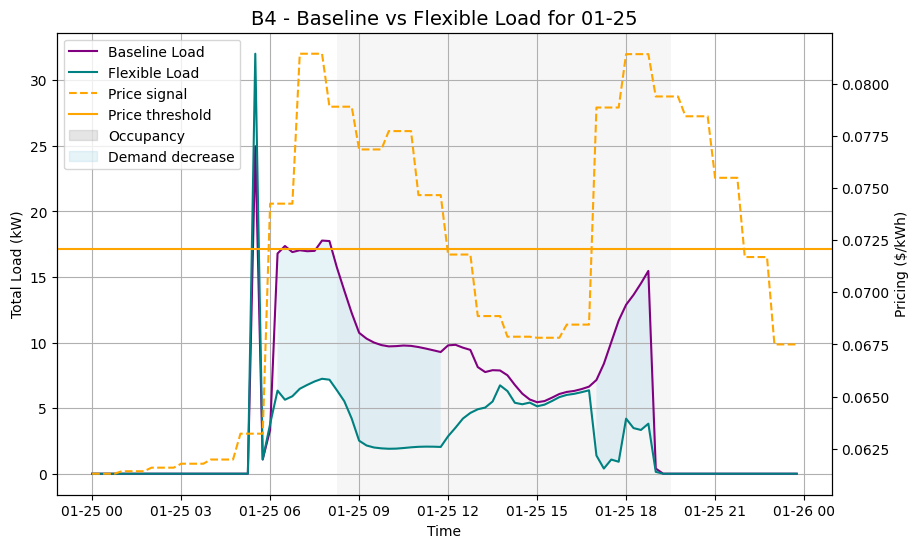

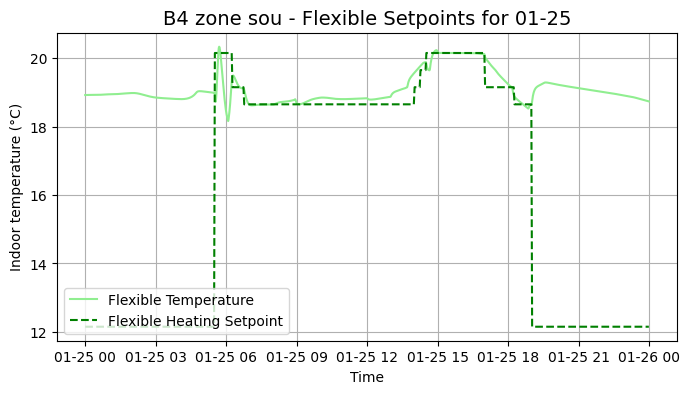

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load datasets
schedule_df = pd.read_csv('scheduleData_dataset.csv')
baseline_df = pd.read_csv('baseline_dataset.csv')
flexible_df = pd.read_csv('flexible_dataset.csv')
baseline_temp_df = pd.read_csv('baseline_tempData_dataset.csv')
flexible_temp_df = pd.read_csv('flexible_tempData_dataset.csv')

# Convert 'time' columns to datetime
schedule_df['time'] = pd.to_datetime(schedule_df['time'])
baseline_df['time'] = pd.to_datetime(baseline_df['time'])
flexible_df['time'] = pd.to_datetime(flexible_df['time'])
baseline_temp_df['time'] = pd.to_datetime(baseline_temp_df['time'])
flexible_temp_df['time'] = pd.to_datetime(flexible_temp_df['time'])

# Resample the data to 15-minute intervals
baseline_resampled_df = baseline_df.resample('15T', on='time').mean()
flexible_resampled_df = flexible_df.resample('15T', on='time').mean()
baseline_temp_resampled_df = baseline_temp_df.resample('1T', on='time').mean()
flexible_temp_resampled_df = flexible_temp_df.resample('1T', on='time').mean()

# Reset the index to make 'time' a column again
baseline_resampled_df.reset_index(inplace=True)
flexible_resampled_df.reset_index(inplace=True)
baseline_temp_resampled_df.reset_index(inplace=True)
flexible_temp_resampled_df.reset_index(inplace=True)

schedule_resampled_df = schedule_df.set_index('time').resample('15T').ffill().reset_index()

# Filter the data for the specific day
baseline_df_selected_day = baseline_resampled_df[baseline_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
flexible_df_selected_day = flexible_resampled_df[flexible_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
schedule_df_selected_day = schedule_resampled_df[schedule_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
baseline_temp_resampled_day_df = baseline_temp_resampled_df[baseline_temp_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]
flexible_temp_resampled_day_df = flexible_temp_resampled_df[flexible_temp_resampled_df['time'].dt.strftime('%Y-%m-%d') == selected_day]


# Calculate total load for baseline and flexible scenarios
baseline_df_selected_day['Total'] = baseline_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW
flexible_df_selected_day['Total'] = flexible_df_selected_day.drop(columns=['time']).sum(axis=1) / 1000  # Convert to kW

# Plot total load over time for baseline and flexible scenarios with occupancy shaded and pricing on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total load
line1, = ax1.plot(baseline_df_selected_day['time'], baseline_df_selected_day['Total'], label='Baseline Load', color='purple')
line2, = ax1.plot(flexible_df_selected_day['time'], flexible_df_selected_day['Total'], label='Flexible Load', color='teal')
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Load (kW)')
ax1.tick_params(axis='y')
plt.grid(True)

# Shade occupancy periods
for i in range(len(schedule_df_selected_day)):
    if schedule_df_selected_day[Occ_identifier].iloc[i] > 0:
        start_time = schedule_df_selected_day['time'].iloc[i]
        end_time = start_time + pd.Timedelta(minutes=15)
        ax1.axvspan(start_time, end_time, alpha=0.2, color='lightgray', ec='none')

# Shade areas between baseline and flexible load where flexible load < baseline load and price > price threshold
ax1.fill_between(
    baseline_df_selected_day['time'],
    flexible_df_selected_day['Total'],
    baseline_df_selected_day['Total'],
    where=(flexible_df_selected_day['Total'] < baseline_df_selected_day['Total']) &
          (schedule_df_selected_day[price_signal_identifier].values > price_threshold),
    facecolor='lightblue',
    alpha=0.3,
    label='Demand decrease'
)

# Create a second y-axis for pricing
ax2 = ax1.twinx()
line3, = ax2.plot(schedule_df_selected_day['time'], schedule_df_selected_day[price_signal_identifier], label='Price signal', linestyle='--', color='orange')
ax2.set_ylabel('Pricing ($/kWh)')
ax2.tick_params(axis='y')

# Add a horizontal line at a specific price value
line4 = ax2.axhline(y=price_threshold, color='orange', linestyle='-', label=f'Price threshold')

# Add a legend for occupancy shading
line5 = mpatches.Patch(color='gray', alpha=0.2, label='Occupancy')
line6 = mpatches.Patch(color='lightblue', alpha=0.3, label='Demand decrease')

# Combine legends from both axes
lines = [line1, line2, line3, line4, line5, line6]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')


plt.title(f'{name_test_case} - Baseline vs Flexible Load for {selected_day[5:]}', fontsize=14)
plt.savefig(f'{scenario_test_case}_{zone}_demand.png', bbox_inches='tight')
plt.show()

# Plot temperature setpoints and actual temperatures for baseline and flexible scenarios for the new day
fig, ax1 = plt.subplots(figsize=(8, 4))


#line1, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[temperature_identifier] - 273, label='Baseline Temperature', color='brown')
line2, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[temperature_identifier] - 273, label='Flexible Temperature', color='lightgreen')
#line3, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[heatStp_identifier] - 273, label='Baseline Heating Setpoint', linestyle='--', color='red')
#line4, = ax1.plot(baseline_temp_resampled_day_df['time'], baseline_temp_resampled_day_df[coolStp_identifier] - 273, label='Baseline Cooling Setpoint', linestyle='--', color='red')
line5, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[heatStp_identifier] - 273, label='Flexible Heating Setpoint', linestyle='--', color='green')
#line6, = ax1.plot(flexible_temp_resampled_day_df['time'], flexible_temp_resampled_day_df[coolStp_identifier] - 273, label='Flexible Cooling Setpoint', linestyle='--', color='green')

ax1.set_xlabel('Time')
ax1.set_ylabel('Indoor temperature (°C)')
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()
# line7, = ax2.plot(schedule_df_selected_day['time'], schedule_df_selected_day[otemp_identifier]-273, label='Outdoor temperature', linestyle=':', color='black')
# ax2.set_ylabel('Outdoor temperature (°C)')
# ax2.tick_params(axis='y')

# Shade occupancy periods
# for i in range(len(schedule_df_selected_day)):
#     if schedule_df_selected_day[Occ_identifier].iloc[i] > 0:
#         start_time = schedule_df_selected_day['time'].iloc[i]
#         end_time = start_time + pd.Timedelta(minutes=15)
#         plt.axvspan(start_time, end_time, alpha=0.2, color='lightgray', ec='none')

# # Add a proxy artist for the occupancy shading
# line8 = mpatches.Patch(color='gray', alpha=0.2, label='Occupancy')

# Combine legends from both axes
lines = [line2, line5] #line1, line2, line3, line4, line5, line6, line7, line8
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')


plt.title(f'{name_test_case} zone {zone} - Flexible Setpoints for {selected_day[5:]}', fontsize=14)
plt.grid(True)
plt.savefig(f'{scenario_test_case}_{zone}_temperature.png', bbox_inches='tight')
plt.show()
